# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, I implement some strategies based on deep neural networks and convolutional neural networks (convNets) to identify traffic signs, basically a classifier. I trained a model use the database provided by [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [1]:
# Import dependencies
from sklearn.utils.multiclass import unique_labels
from IPython.display import clear_output, display
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import glob
import sys
import cv2
import csv
import os

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.|
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
# Directory where the data files are saved.
training_file = "../data/train.p"
validation_file = "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Saved the features and labels.
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Create random order in the dataset
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

### Basic Summary of the Data Set
To provide the basic summary of the Data Set, I used Python to create a dictionary.

In [3]:
def duplicates(lst, item):
    """
    Description:
        returns a list with indexes where element 'item' is repeated in list 'lst'
    Inputs:
        lst: `list` list to look for repeated elements  
        item: `undefined` elements to look indexes where is repeated in list 'lst'
    Outputs: 
        list with indexes where the element is repeated in input list
    Resources:
        N/A.
    """
    return [i for i, x in enumerate(lst) if x == item]

def summary_data_sets(y_train, y_valid, y_test, csv_name):
    """
    Description:
        Returns a list of dictionaries with datasets information
    Inputs:
        y_train: `list` labels of training dataset
        y_valid: `list` labels of validations dataset
        y_test: `list` labels of testing dataset
    Outputs:
        classes_dics: `list` dictionaries with datasets information
    Resources:
        N/A.
    """
    
    #Create an empty list
    classes_dics = []

    # From csv I scrapped some data to get the descriptions and classes
    with open(csv_name) as csv_file:
        
        csv_reader = csv.reader(csv_file, delimiter=',')
        
        for idx, row in enumerate(csv_reader):

            if idx > 0:

                # Extract index with samples belonging to idx class
                #duplicates retorna el indice de donde se repite
                #train_idx,valid_idx son listas de indexes
                train_idx = duplicates(list(y_train), int(row[0]))
                valid_idx = duplicates(list(y_valid), int(row[0]))
                test_idx = duplicates(list(y_test), int(row[0]))

                # Append new information for class idx
                classes_dics.append({
                    "id": int(row[0]), # Find the image label
                    "description": row[1], # Find the Sign name
                    "train": len(train_idx),
                    "vali": len(valid_idx), 
                    "test": len(test_idx), 
                    "train_idx": train_idx, 
                    "vali_idx": valid_idx,
                    "test_idx": test_idx})
                
    return classes_dics # Return a list of dictionaries

In [4]:
# Get summary of datasets
classes_dics_raw = summary_data_sets(y_train, y_valid, y_test, 'signnames.csv')

# Unique classes/labels in the dataset.
n_classes = len(classes_dics_raw)

In [5]:
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = n_classes

n_total = n_test + n_validation + n_train # Total number of samples in dataset

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Total number of samples in dataset =", n_total)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Total number of samples in dataset = 51839


In [6]:
# Print datasets report
print(" ID\t Train\t\t validation\t testing\t")
for dic in classes_dics_raw:
    #print("| {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t|  {}".format(
    print(" {}\t {:.2f}% -> {}\t {:.2f}% -> {}\t {:.2f}% -> {}\t  {}".format(

        dic["id"], dic["train"]/n_train*100, dic["train"], dic["vali"]/n_validation*100, dic["vali"], 
        dic["test"]/n_test*100, dic["test"], dic["description"][0:30]))

 ID	 Train		 validation	 testing	
 0	 0.52% -> 180	 0.68% -> 30	 0.48% -> 60	  Speed limit (20km/h)
 1	 5.69% -> 1980	 5.44% -> 240	 5.70% -> 720	  Speed limit (30km/h)
 2	 5.78% -> 2010	 5.44% -> 240	 5.94% -> 750	  Speed limit (50km/h)
 3	 3.62% -> 1260	 3.40% -> 150	 3.56% -> 450	  Speed limit (60km/h)
 4	 5.09% -> 1770	 4.76% -> 210	 5.23% -> 660	  Speed limit (70km/h)
 5	 4.74% -> 1650	 4.76% -> 210	 4.99% -> 630	  Speed limit (80km/h)
 6	 1.03% -> 360	 1.36% -> 60	 1.19% -> 150	  End of speed limit (80km/h)
 7	 3.71% -> 1290	 3.40% -> 150	 3.56% -> 450	  Speed limit (100km/h)
 8	 3.62% -> 1260	 3.40% -> 150	 3.56% -> 450	  Speed limit (120km/h)
 9	 3.79% -> 1320	 3.40% -> 150	 3.80% -> 480	  No passing
 10	 5.17% -> 1800	 4.76% -> 210	 5.23% -> 660	  No passing for vehicles over 3
 11	 3.36% -> 1170	 3.40% -> 150	 3.33% -> 420	  Right-of-way at the next inter
 12	 5.43% -> 1890	 4.76% -> 210	 5.46% -> 690	  Priority road
 13	 5.52% -> 1920	 5.44% -> 240	 5.70% -> 720	  Yield
 14	

### Exploratory visualization of the dataset

In [7]:
def show_dataset(data, classes_dics, data_label, save_name = None):
    """
    Description:
        This function shows samples of the data set randomly.
    Inputs:
        data: `np.darray` dataset samples
        classes_dics: `list` dictionaries with datasets information
        data_label: `string` dataset base name
        save_name: `string` absolute path to save plot
    Outputs:
        N/A.
    Resources:
        N/A.
    """
    
    columns = 7
    plt.figure(figsize=(20,30))
    n_classes = len(classes_dics)
    
    for idx in range(0, n_classes):
        len_idx = len(classes_dics[idx][data_label+"_idx"])
        idx_data = classes_dics[idx][data_label+"_idx"][np.random.randint(len_idx)]
        ax = plt.subplot(np.ceil(n_classes/columns), columns, idx + 1)
        plt.imshow(data[idx_data])
        ax.set_xlabel(str(idx) + ": " + classes_dics[idx]["description"][0:20])
    
    if save_name is not None:
        plt.savefig(save_name)
    
    plt.show()

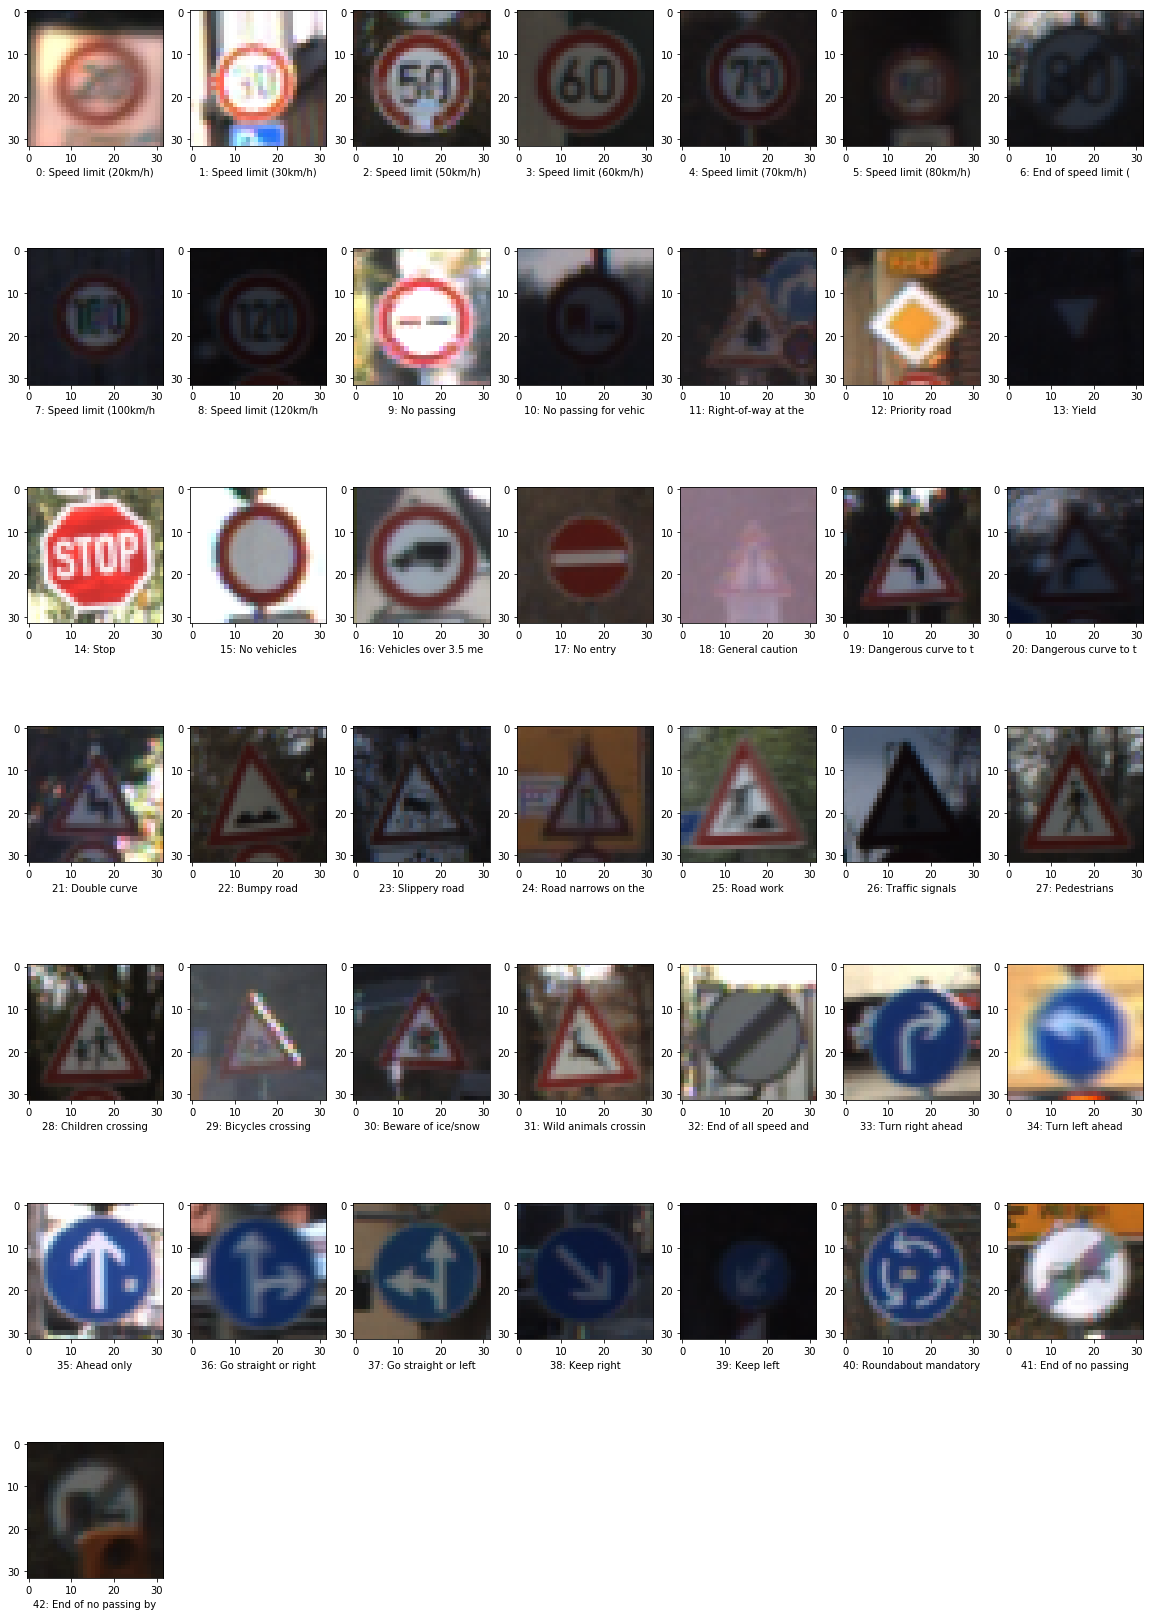

In [8]:
# Show random  datasets samples 
show_dataset(X_train, classes_dics_raw, data_label = "train", 
             save_name = 'writeup_files/dataset_random_visualization.png')

In [9]:
def plot_dataset(means_training, means_validation, means_test, n_classes, save_name = None):
    """
    Description:
        plots dataset data distribution
    Inputs:
        means_training: `list` list with the amount of training samples for each class 
        means_validation: `list` list with the amount of validation samples for each class
        means_test: `list` list with the amount of testing samples for each class
    Outputs:
        N/A.
    Resources:
        N/A.
    """
    
    # Plot parameters
    plt.rcParams["figure.figsize"] = (13,4)
    fig, ax = plt.subplots()
    index = np.arange(n_classes)
    bar_width = 0.25
    alpha = 0.3
    # Plot training, validation and test datasets
    rects1 = ax.bar(index, means_training, bar_width, alpha, align='edge', color='c', label='Training')
    rects2 = ax.bar(index + bar_width, means_validation, bar_width, alpha, align='edge', color='g', label='Validation')
    rects3 = ax.bar(index + 2*bar_width, means_test, bar_width, alpha, align='edge', color='y', label='Test')

    # Plotting the graph
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Dataset Description')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(map(str, range(n_classes + 1)))
    ax.legend()
    fig.tight_layout()
    
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    

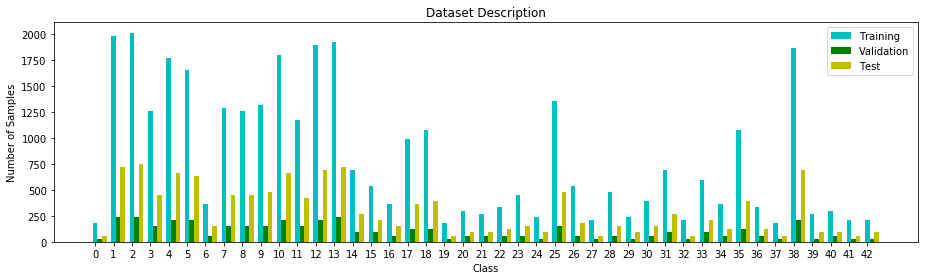

In [10]:
# Get the total of samples for each class in validation, training and testing datasets
means_validation = [d['vali'] for d in classes_dics_raw if 'vali' in d]
means_training = [d['train'] for d in classes_dics_raw if 'train' in d]
means_test = [d['test'] for d in classes_dics_raw if 'test' in d]

# Plot the datasets distribution
plot_dataset(means_training, means_validation, means_test, 
             n_classes,save_name = 'writeup_files/dataset_description_original_data.png')

## Step 2: Design and Test a Model Architecture

Find below the design and the implementation of a deep learning model that learns to ecognize traffic signs. Trained and tested with the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

A solid starting point is use the LeNet-5 implementation shown in the classroom. Basically, I changed the number of class and some layers, but eventually is the same architecture. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)
Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project.

In [11]:
def norm(img):
    """
    Description:
        Normalizes a image with mean zero
    Inputs:
        img: `np.darray` image to convert to gray
    Outputs:
        dst: `np.darray` image normalized
    Resources:
        N/A.
    """

    if img.dtype == np.uint8:
        dst = np.array((img-128.)/128., dtype=np.float32)
    return dst

In [29]:
# Parameters
DATA_SRC_SIZE = (32, 32)
MODEL_NAME = "J2Net"
BATCH_SIZE = 128
#LEARNING_RATE = 0.0005
LEARNING_RATE = 0.0006
NUM_CHANNELS = 3
EPOCHS = 150
DATA_AUGMENTA = 0

In [30]:
# Dataset selection and adjusments
if NUM_CHANNELS == 1: # Convert dataset to gray scale
    X_train_1 = np.asarray([norm(gray(img)) for img in (X_train_aug if DATA_AUGMENTA else X_train)])
    X_valid_1 = np.asarray([norm(gray(img)) for img in X_valid])
    X_test_1 = np.asarray([norm(gray(img)) for img in X_test])
else:
    X_train_1 = np.asarray([norm(img) for img in (X_train_aug if DATA_AUGMENTA else X_train)])
    X_valid_1 = np.asarray([norm(img) for img in X_valid])
    X_test_1 = np.asarray([norm(img) for img in X_test])
    
y_train_1 = y_train_aug if DATA_AUGMENTA else y_train
y_valid_1 = y_valid
y_test_1  = y_test

### Model Architecture

| **Layer** | **Description** |
| ------------- | ------------- :|
| *Input* | `32x32x3 RGB image` |
| *Convolution 5x5* | 1x1 stride, valid padding, outputs 28x28x24 |
| *Relu* |
| *Max pooling* | 2x2 stride, outputs 14x14x24 |
| *Convolution 5x5* | 1x1 stride, valid padding, outputs 10x10x64 |
| *Relu* |
| *Max pooling* | 2x2 stride, valid padding, outputs 5x5x64 |
| *Flatten* |
| *Dropout* |
| *Fully connected* | outputs 120 |
| *Relu* |
| *Dropout* |
| *Fully connected* | outputs 84 |
| *Relu* |
| *Dropout* |
| *Fully connected* | outputs 43 |

In [31]:
def J2Net(x, keep_prob, mu = 0, sigma = 0.1, ):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases 
    # for each layer
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28xconv_1_d.
    conv_1_d = 24
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, NUM_CHANNELS, conv_1_d), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(conv_1_d))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28xconv_1_d. Output = 14x14xconv_1_d
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14xconv_1_d Output = 10x10xconv_2_d.
    conv_2_d = 64
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv_1_d, conv_2_d), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(conv_2_d))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2) # Activation.
    
    # Pooling. Input = 10x10xconv_2_d. Output = 5x5xconv_2_d.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5xconv_2_d. Output = 1600.
    fc0 = flatten(conv2)
    fc0  = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1) # Activation.
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2) # Activation.
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

### Train, Validate and Test the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [32]:
# Evaluate how well the loss and accuracy of the model for a given dataset.

def evaluate(X_data, y_data):
    
    num_examples = float(len(X_data))
    total_accuracy = 0.
    sess = tf.get_default_session()

    for offset in range(0, int(num_examples), BATCH_SIZE):        
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, kp: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


tf.reset_default_graph() # Reset any previous graph

x = tf.placeholder(tf.float32, (None, DATA_SRC_SIZE[0], DATA_SRC_SIZE[1], NUM_CHANNELS))

y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, n_classes)

kp = tf.placeholder(tf.float32) # Probability for dropout

logits, conv1, conv2 = J2Net(x, kp)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)

training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

In [33]:
# Training history variables
best_epoch = 0
best_val_acc = 0
history = []
patience = int(EPOCHS*0.5)
keep_prob = 0.5

with tf.Session() as sess:
            
    sess.run(tf.global_variables_initializer())
    print("Training the model {}...".format(MODEL_NAME))
    
    try:
        for i in range(EPOCHS):
            
            # shuffle data
            X_train_1, y_train_1 = shuffle(X_train_1, y_train_1)
            
            for offset in range(0, len(X_train_1), BATCH_SIZE):
                end = offset + BATCH_SIZE
                # Select training batch
                batch_x, batch_y = X_train_1[offset:end], y_train_1[offset:end]
                # Run train for batch
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, kp: keep_prob})
                
            # Evaluate model at epoch
            train_acc = evaluate(X_train_1, y_train_1)
            valid_acc = evaluate(X_valid_1, y_valid_1)
                     
            # Print training process information
            clear_output(wait=True)
            print("EPOCH {}: Tra_Acc:{:.3f} - Val_Acc:{:.3f} - Best_Val_Acc:{:.3f}".format(
                i+1, train_acc, valid_acc, best_val_acc))
            
            history.append([train_acc, valid_acc])   
            if valid_acc > best_val_acc:
                best_epoch, best_val_acc = i, valid_acc
                saver.save(sess, './model_results/{}.ckpt'.format(MODEL_NAME))
                print("Model saved")
            else:
                if i - best_epoch == patience:
                    print('Stopping after {} epochs without improvement'.format(patience))
                    break
        print("Training has finished")

    except KeyboardInterrupt:
        pass


EPOCH 150: Tra_Acc:1.000 - Val_Acc:0.987 - Best_Val_Acc:0.989
Training has finished


### Report the accuracy on the training and validation set

In [34]:
def plot_history(history, save_name=None):

    A4_PORTRAIT = (8.27, 11.69)
    A4_LANDSCAPE = A4_PORTRAIT[::-1]

    plt.figure(figsize=A4_LANDSCAPE)
    plt.title('Model training history: {}'.format("model_training"))
    plt.plot(history)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    if save_name is not None:
        plt.savefig(save_name)

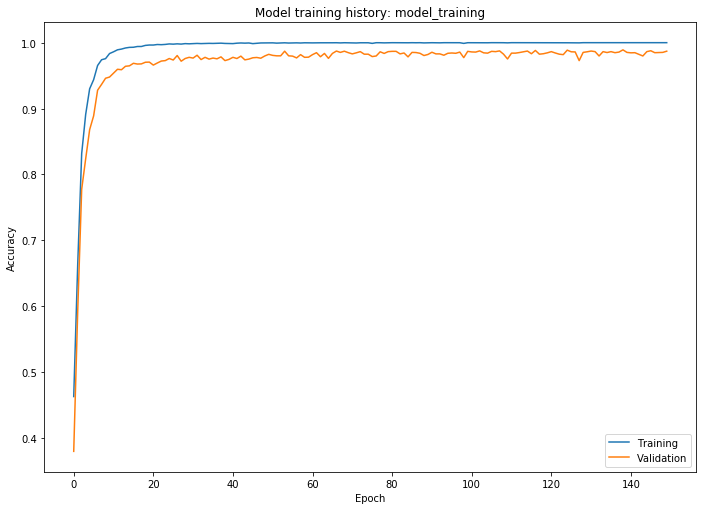

In [35]:
# Training visualization
plot_history(history, "model_results/model_traing_history.png")

## Testing The Model With Test Dataset¶

In [36]:
# Restore the session
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model_results'))
    
    # Evaluate the testing dataset
    test_accuracy = evaluate(X_test, y_test)
    print('Test accuracy: {:.3f}%'.format(test_accuracy* 100))
    
    # Take softmax from logits to get predictions
    softmax = tf.nn.softmax(logits)
    t_pred = None
    
    # Select testing batch and test
    for offset in range(0, len(X_test), BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_test[offset:end], y_test[offset:end]
        top_softmax = sess.run(tf.nn.top_k(softmax, k=3), feed_dict={x: batch_x, y: batch_y, kp: 1.0})
    
        if t_pred is None:
            t_pred = top_softmax[1]
        else:
            t_pred = np.concatenate([t_pred, top_softmax[1]])
    
    correct = np.sum([1 for t_pred, actual in zip(t_pred, y_test) if actual in t_pred])
    print('Top-3 test accuracy: {:.3f}%'.format(100 * correct / len(y_test)))

INFO:tensorflow:Restoring parameters from ./model_results/J2Net.ckpt
Test accuracy: 90.158%
Top-3 test accuracy: 93.943%


In [37]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, figsize=(300,40)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

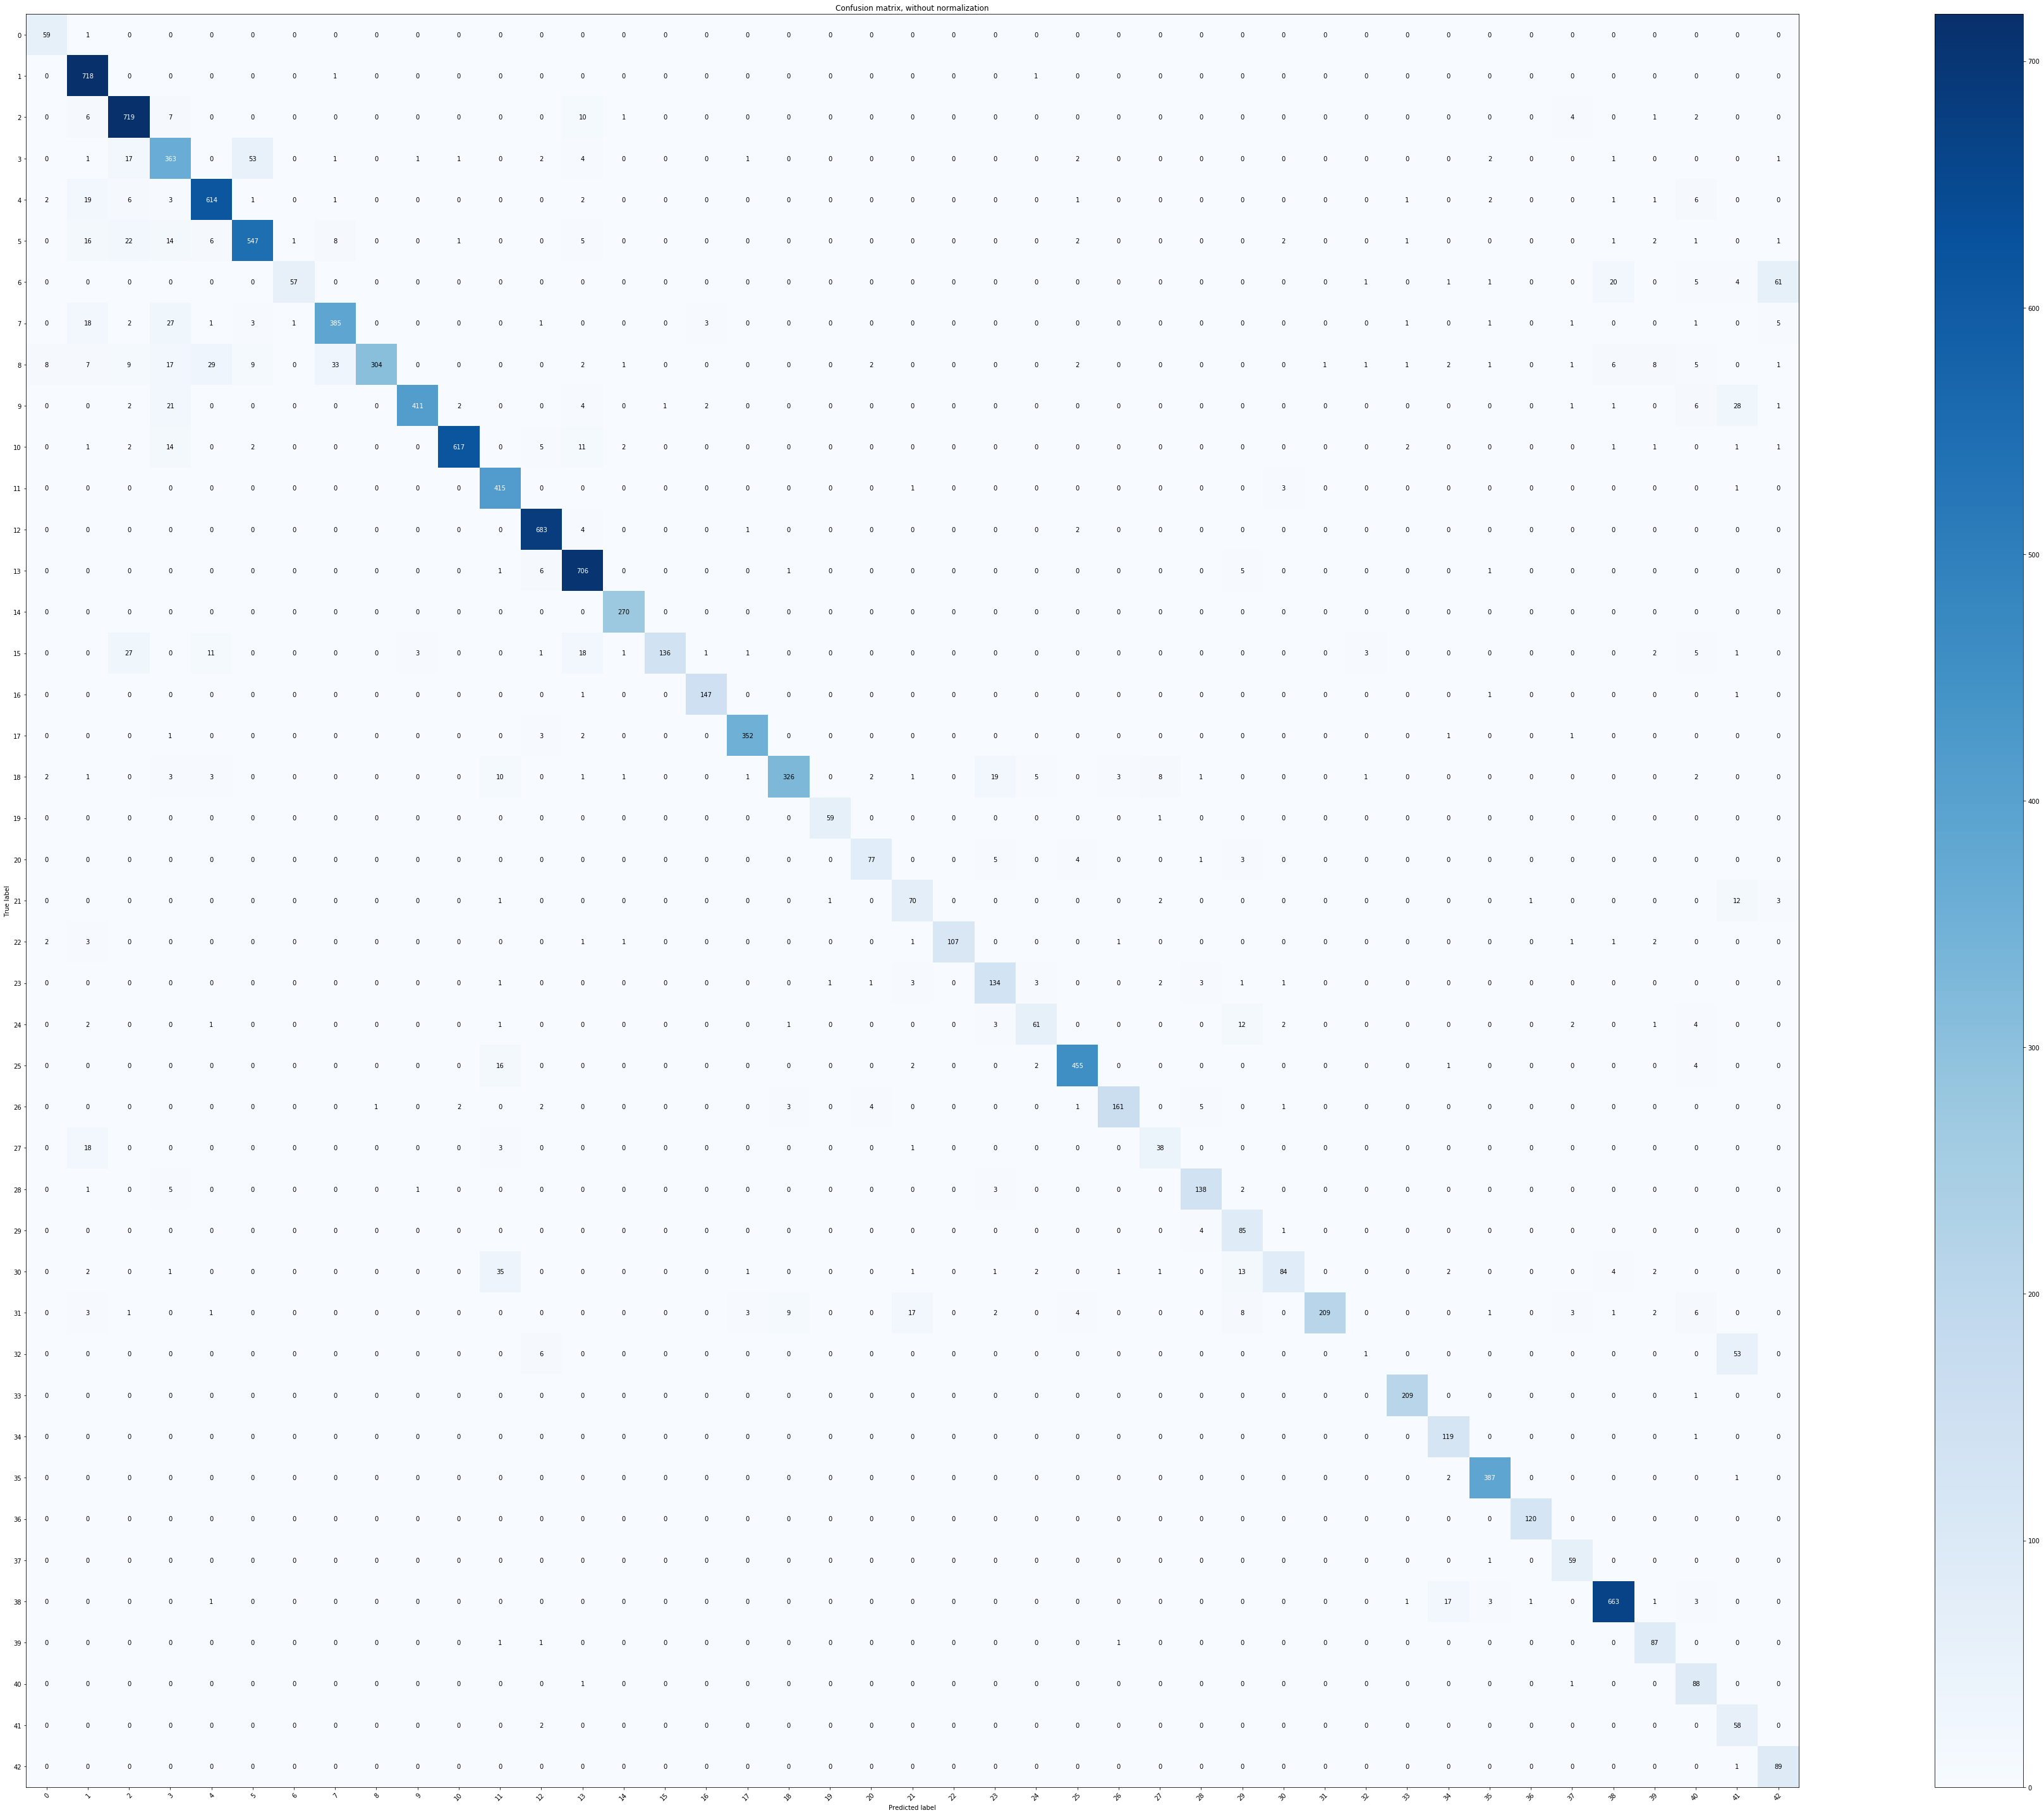

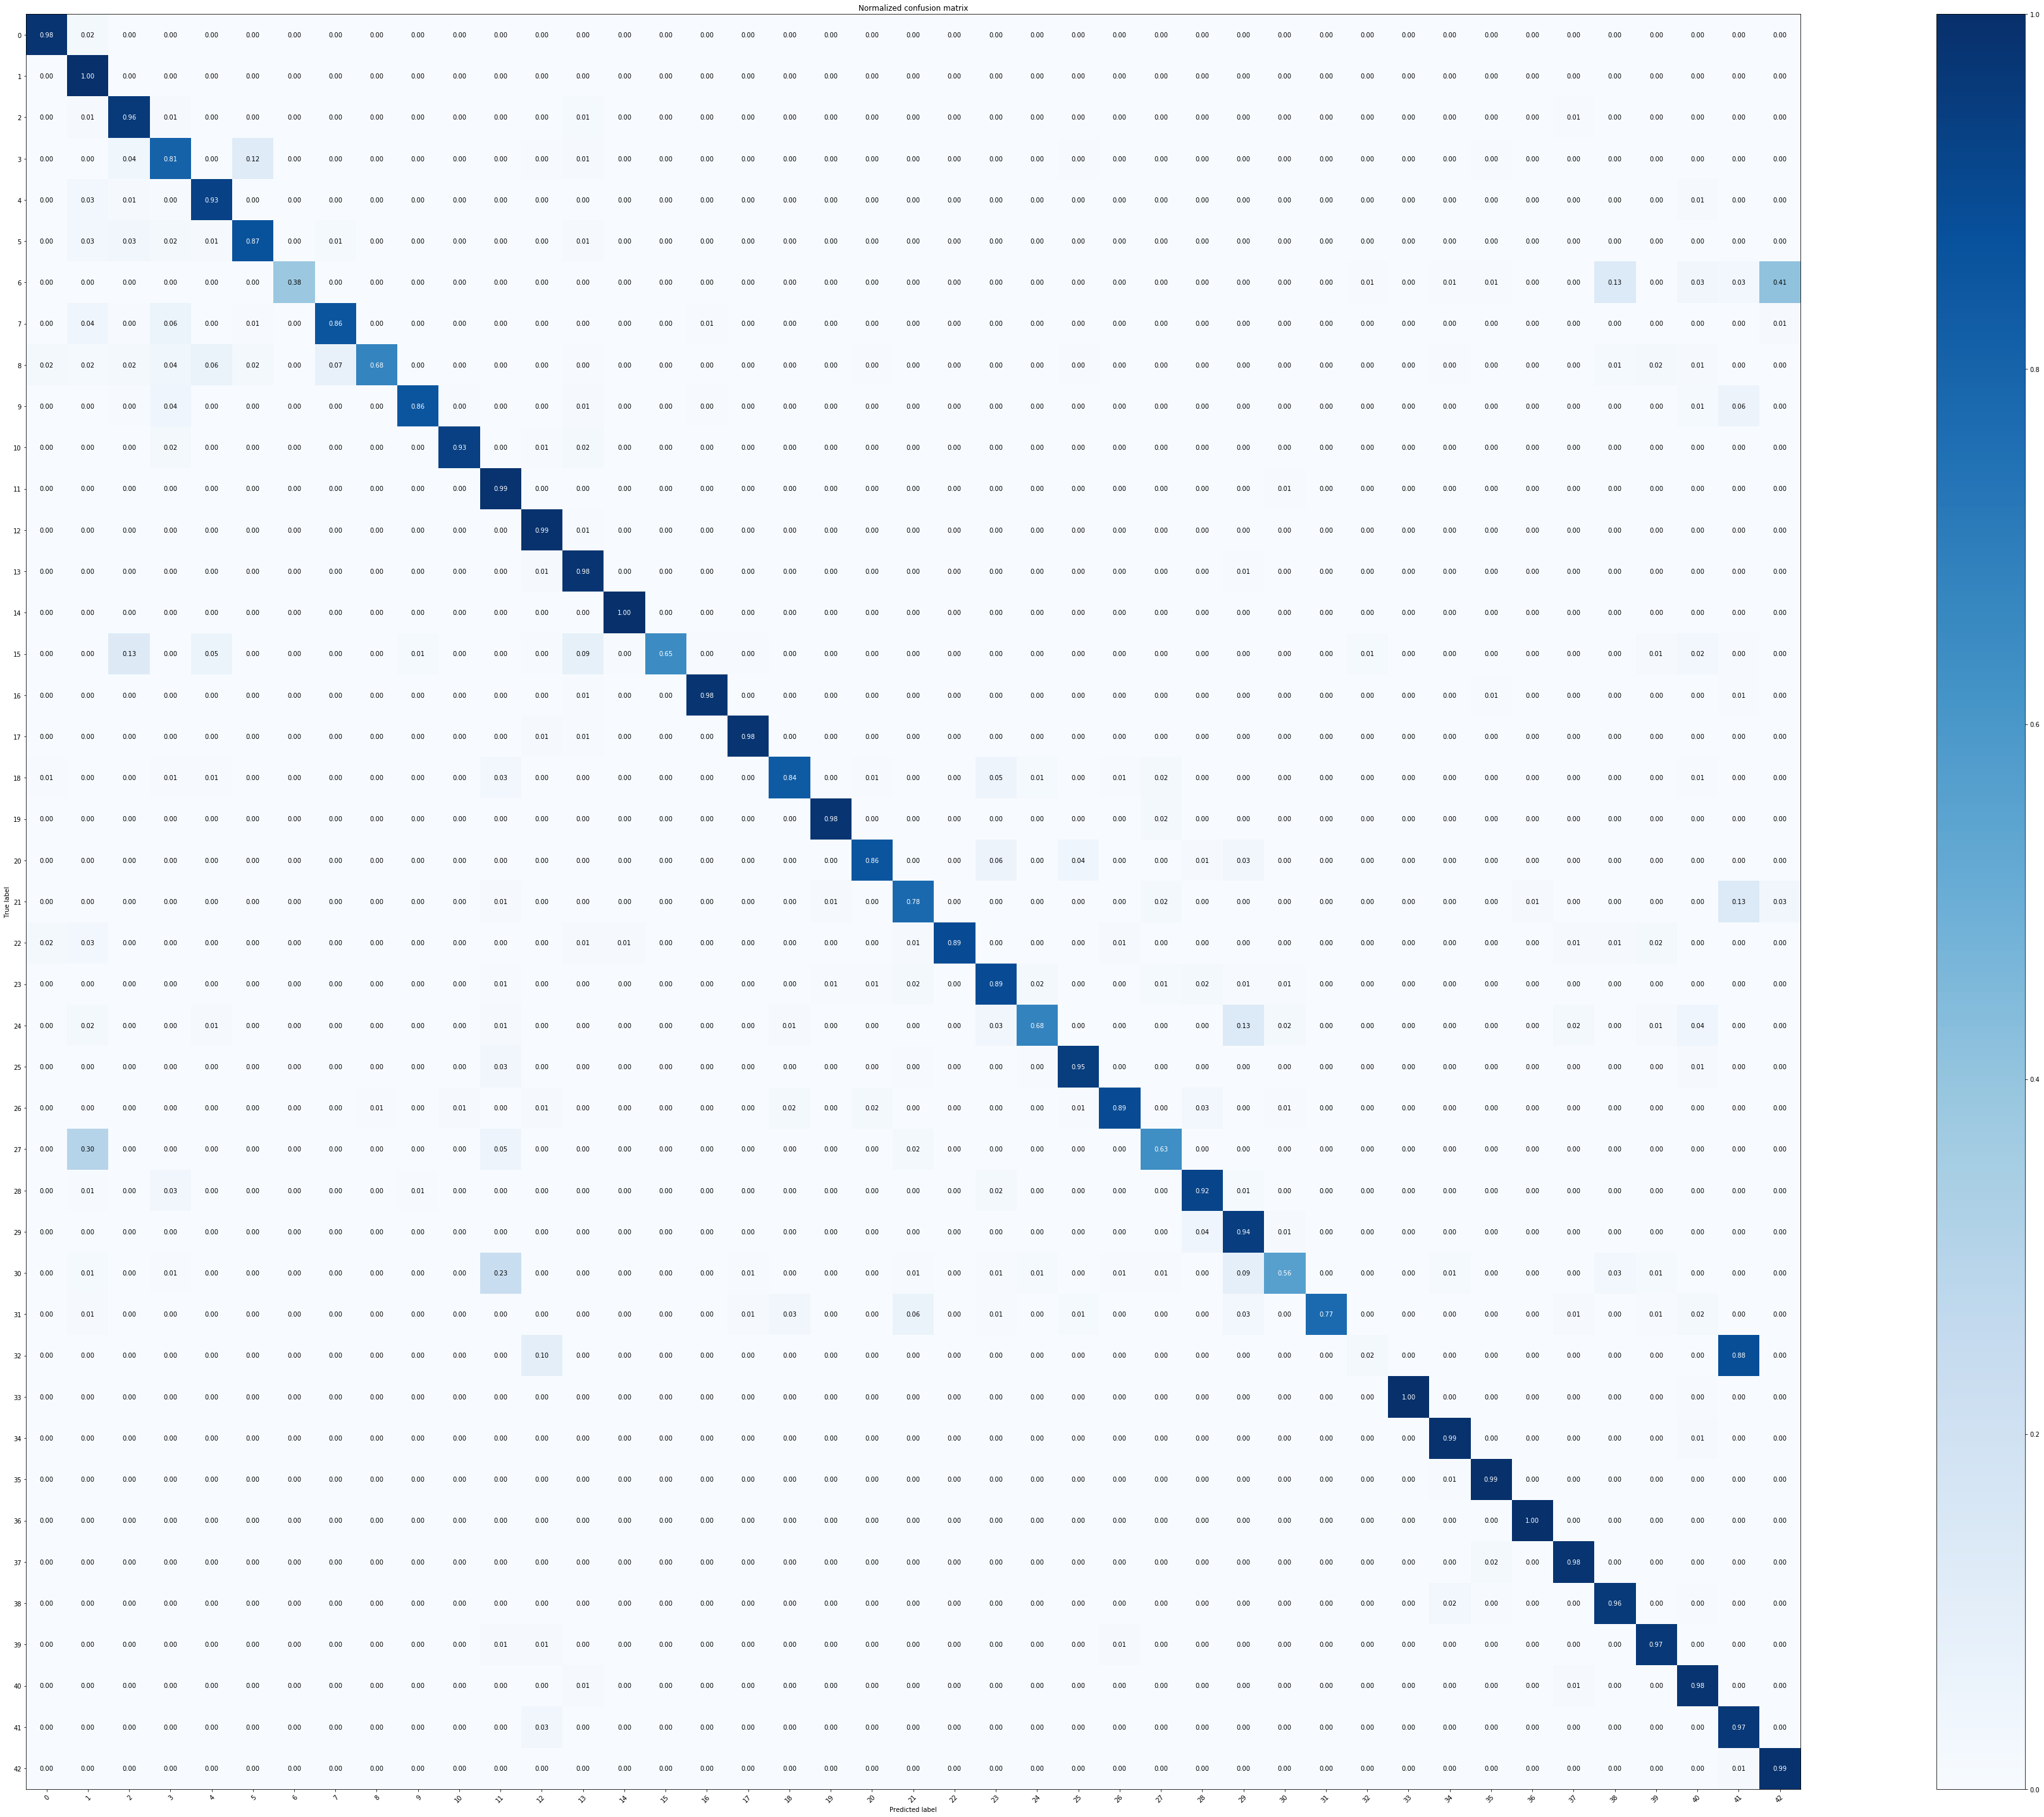

In [38]:
np.set_printoptions(precision=2)
classes_names= np.asarray([str(i) for i in range(n_classes)])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, t_pred[:, 0], classes=classes_names, 
                      title='Confusion matrix, without normalization', figsize=(60,40))
plt.savefig("./writeup_files/Confusion_matrix_without_normalization.png")

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, t_pred[:, 0], classes=classes_names, normalize=True,
                      title='Normalized confusion matrix', figsize=(60,40))
plt.savefig("./writeup_files/Normalized_confusion_matrix.png")

plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [39]:
def load_new_data(path, image_shape=(32,32), plot=True, save_name=None, n_classes=43):

    extensions = ["jpg","gif","png","tga"]

    # Load images in 'path'
    image_path_list = [item for i in [glob.glob(path+'/*.%s' % ext) for ext in extensions] for item in i]
    X_test_new = np.asarray([cv2.cvtColor(cv2.resize(cv2.imread(img_path),image_shape[:2]), cv2.COLOR_BGR2RGB) \
                  for idx, img_path in enumerate(image_path_list)])
    y_test_new = [int(os.path.splitext(path)[0].split("_")[-1]) for path in image_path_list]

    if plot:
        # Visualize new dataset
        plt.figure(figsize=(20,30)); columns = 6
        for idx in range(0, len(X_test_new) if len(X_test_new) <= 12 else 12):
            ax = plt.subplot(np.ceil(n_classes/columns), columns, idx + 1)
            plt.imshow(X_test_new[idx])
            ax.set_xlabel(str(idx)+": "+image_path_list[idx].split("/")[-1].split(".")[0][0:15])
        if save_name is not None:
            plt.savefig(save_name)
        plt.show()

    return X_test_new, y_test_new

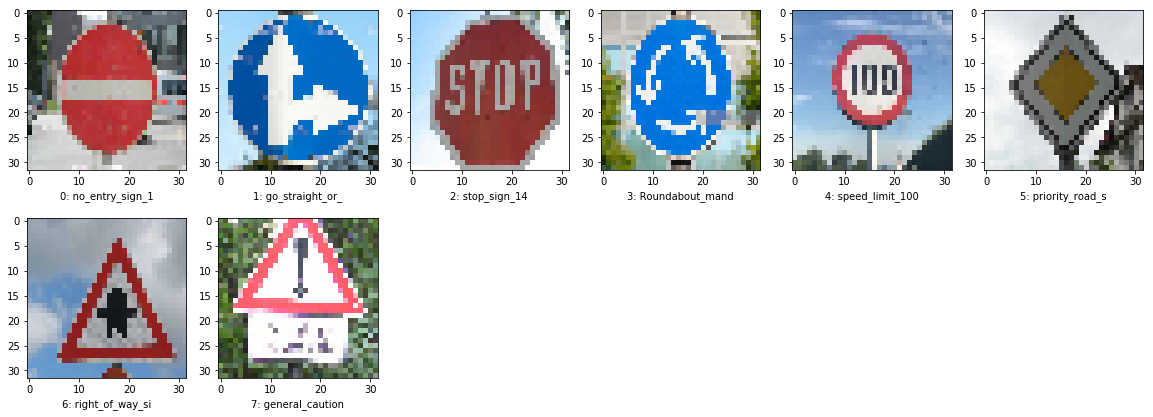

In [40]:
# Load new testing dataset
X_test_new, y_test_new = load_new_data("../data/other_images_internet", (32, 32), True, None)
X_test_new = np.asarray([norm(gray(img)) for img in X_test_new]) if NUM_CHANNELS == 1 else np.asarray([norm(img) for img in X_test_new])

### Predict the Sign Type for Each Image

In [41]:
# Run classifier with new testing samples
k = 5
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model_results'))
    softmax = tf.nn.softmax(logits)
    top_softmax = sess.run(tf.nn.top_k(softmax, k=k), feed_dict={x: X_test_new, kp: 1.0})

INFO:tensorflow:Restoring parameters from ./model_results/J2Net.ckpt


### Analyze Performance

New Test accuracy: 75.000%


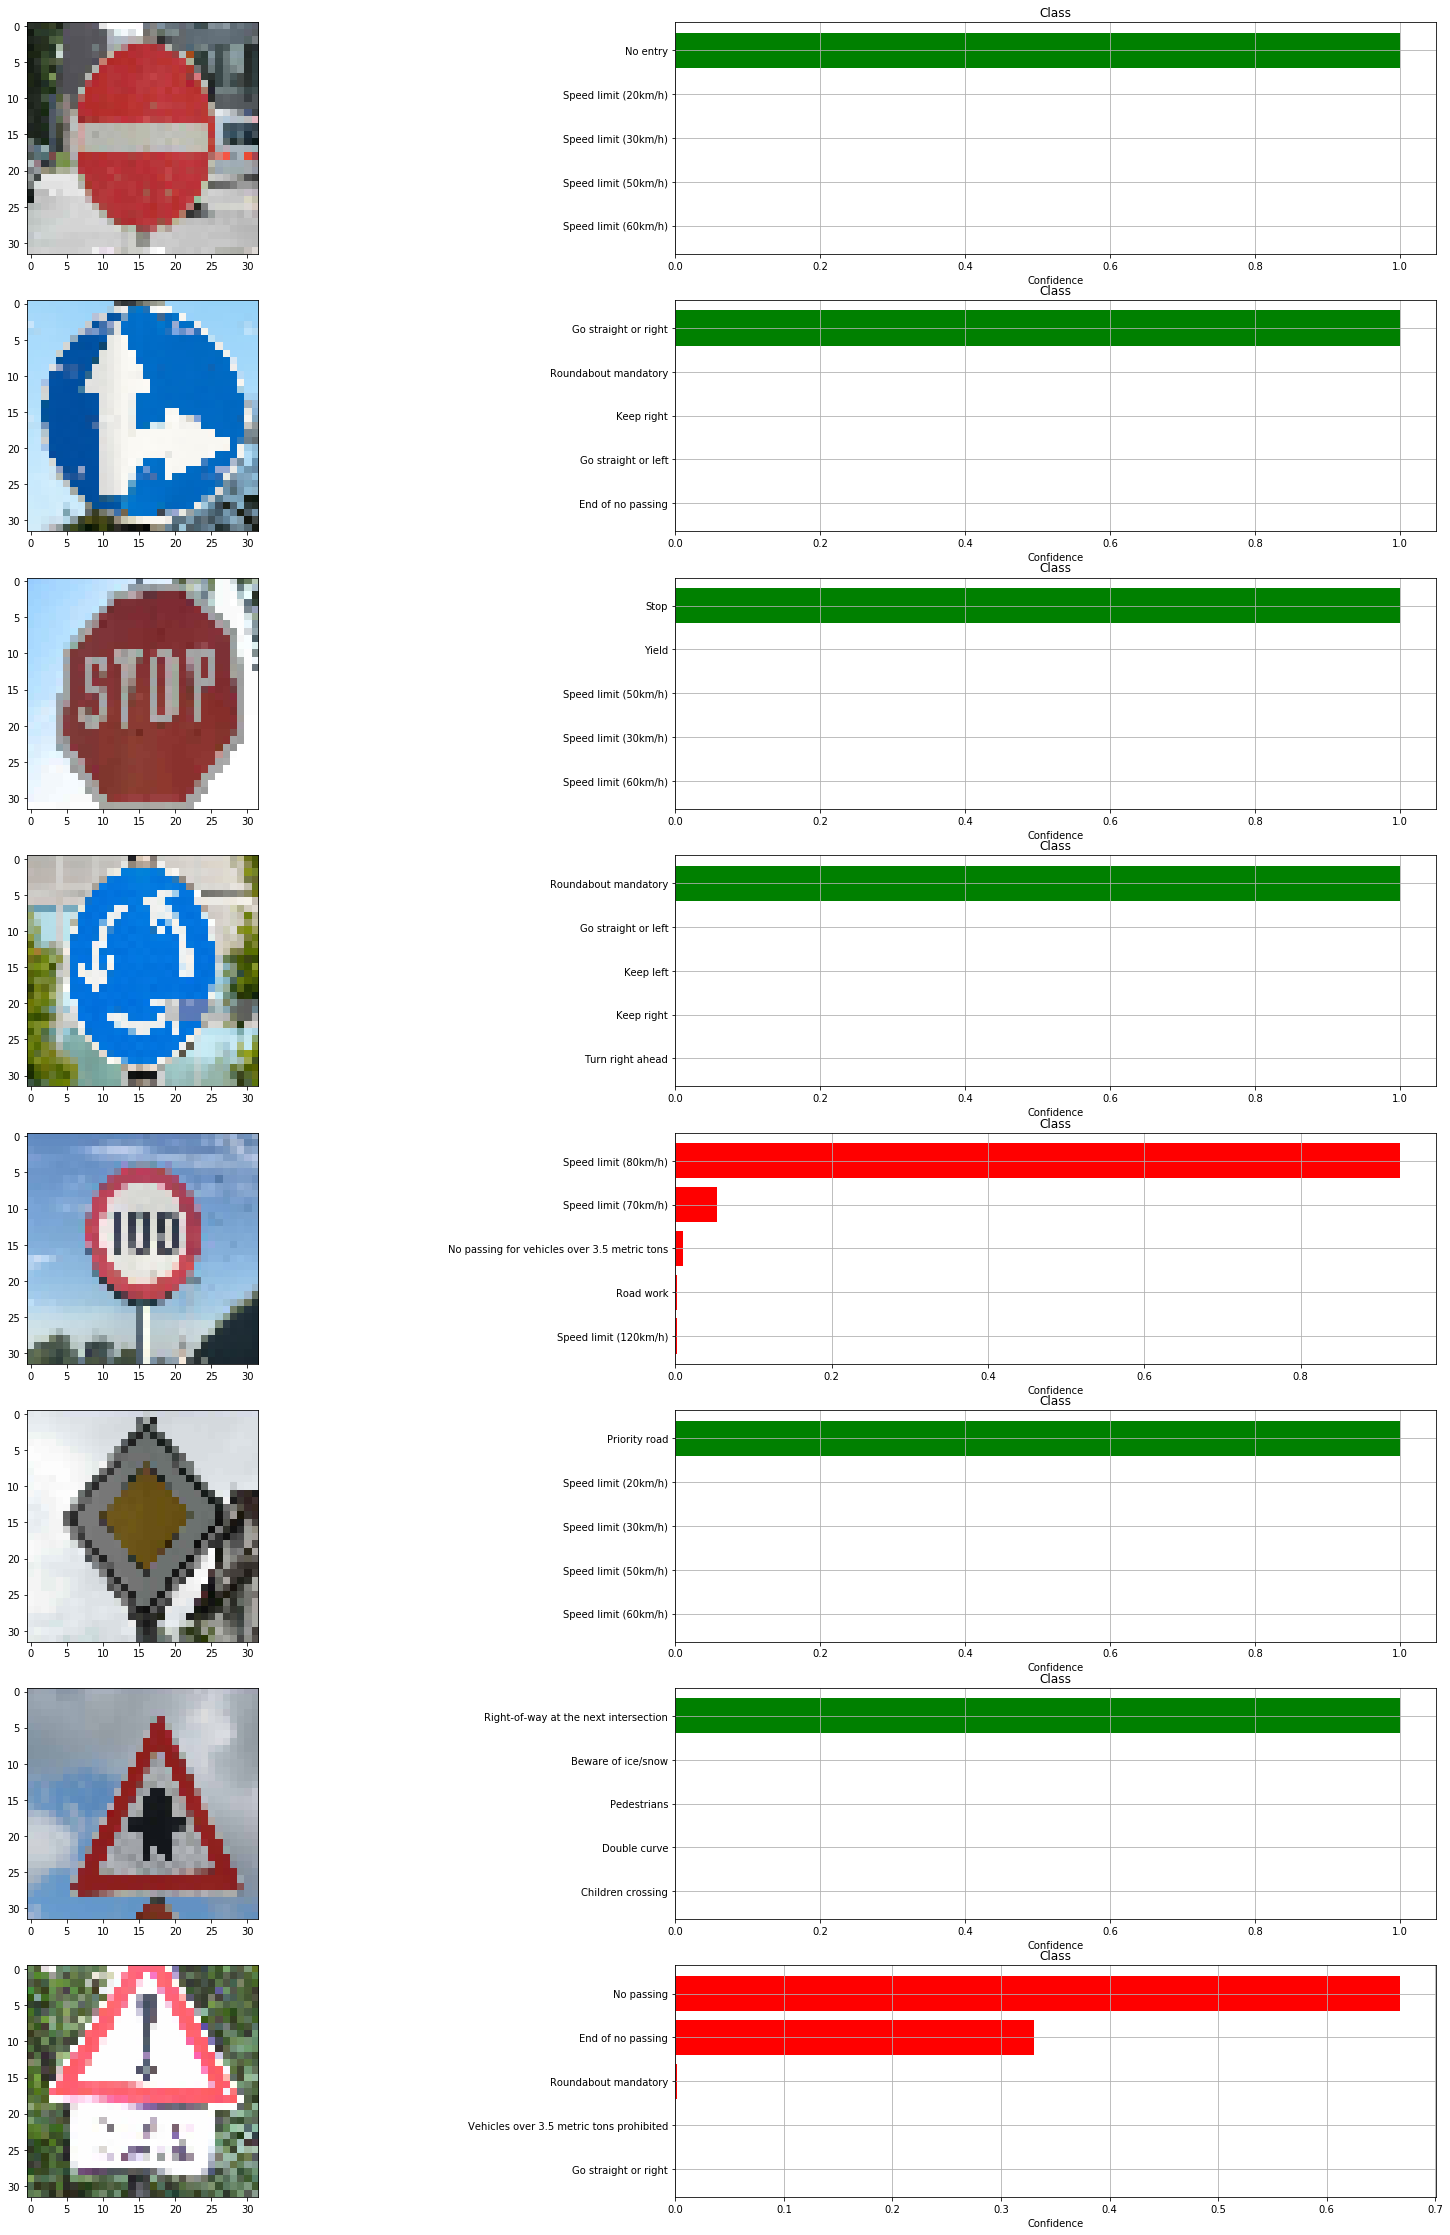

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

plt.figure(figsize=(30,40))
acuaracy = 0
for idx in range(0, len(X_test_new)):
    
    # Evaluate acuaracy
    acuaracy=acuaracy+1 if top_softmax[1][idx][0] == y_test_new[idx] else acuaracy
    # Plot image
    ax = plt.subplot(len(X_test_new), 2, 1+2*idx)
    plt.imshow(np.array(X_test_new[idx]*128+128, dtype='uint8'))
    
    # Plot probabilities
    classes = [classes_dics_raw[top_softmax[1][idx][i]]['description'] for i in range(k)]
    y_pos = np.arange(len(classes))+0.5
    Confidence = top_softmax[0][idx]     
    color = 'green' if top_softmax[1][idx][0] == y_test_new[idx] else 'red'
    ax = plt.subplot(len(X_test_new), 2, 2*(1+idx))
    ax.barh(y_pos, Confidence, align='center',color=color, ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  
    ax.set_xlabel('Confidence')
    ax.set_title('Class')
    ax.grid(True)
    
plt.savefig("model_results/new_dataset_testing.png")
print('New Test accuracy: {:.3f}%'.format(acuaracy*100./len(X_test_new)))
    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [43]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,
                     plt_num=1, save_name = None, fig_size=(15,15)):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize= fig_size)
    for featuremap in range(featuremaps):
        plt.subplot(np.ceil(featuremaps/2), 6, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        if save_name is not None:
            plt.savefig(save_name)

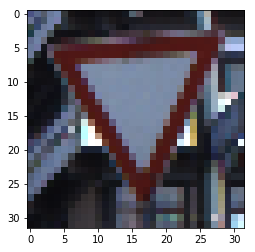

In [44]:
idx = np.random.randint(len(X_test))
plt.imshow(X_test[idx])

INFO:tensorflow:Restoring parameters from ./model_results/J2Net.ckpt
Test Accuracy = 0.902


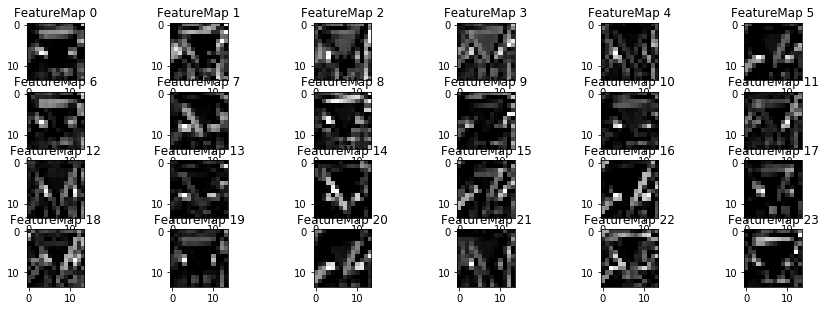

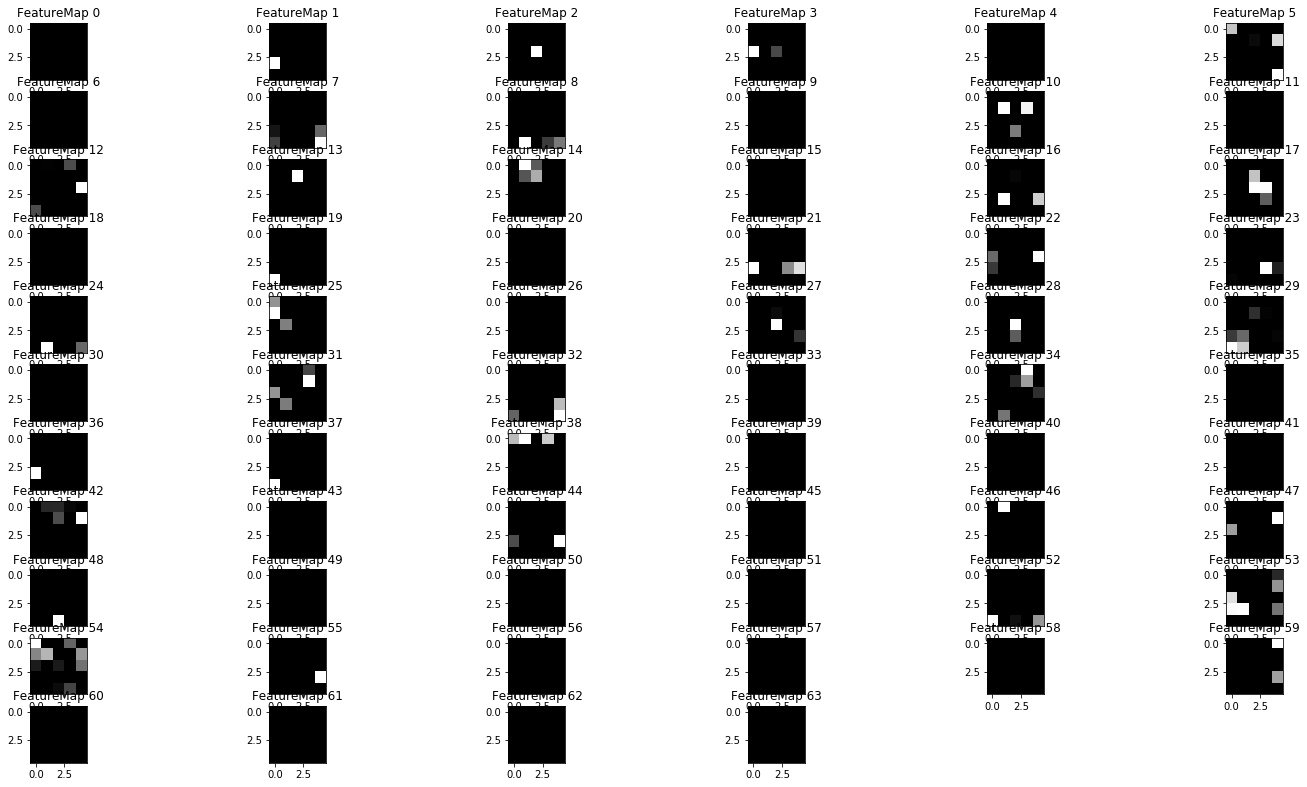

In [45]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model_results'))
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    outputFeatureMap([X_test[idx]], conv1, plt_num=1, save_name = "writeup_files/visualization_layer_1.png", fig_size=(15, 15))
    outputFeatureMap([X_test[idx]], conv2, plt_num=2, save_name = "writeup_files/visualization_layer_2.png", fig_size=(25, 40))